purpose: sister notebook to EFO_analysis_GWAS_cat.ipynb. Exploratory factor ontology is the structure used by the GWAS catalog, but it is difficult to parse, so the people at RGD have mapped the EFO URI traits into the mammalian phenotype ontology (as well as other ontologies, found here: https://download.rgd.mcw.edu/ontology/mappings/).

The purpose of this notebook is to use the RGD's mapping to test validation for externalizing-locomotor network using the RGD's mappings to the MP, so that it parallels the MGI validation. Mapping download link for MP specifically: https://download.rgd.mcw.edu/ontology/mappings/efo_mp_rgd.sssom.tsv.txt

# set-up

In [1]:
import os
from network_functions import *
from network_validation_functions import *
from plotting_functions import *
#os.chdir('/tscc/projects/ps-palmer/brittany/ddot')
#import ddot
from netcoloc import netprop_zscore, netprop, network_colocalization, validation

In [2]:
import pandas as pd
import obonet as obo
import networkx as nx
import ndex2
import numpy as np
import matplotlib.pyplot as plt
from upsetplot import plot as upplot
from upsetplot import from_contents
from upsetplot import UpSet
import scipy.stats as stats
from adjustText import adjust_text
import requests


In [3]:
os.chdir('/tscc/projects/ps-palmer/brittany/SUD_cross_species/')

In [4]:
save_fig=True

# import network genelists

## Interactome Set-up

pcnet2- versions 
from wright et al. 2024 preprint:
PCNet 2.0= best-performing ranked composite (top 15 interactomes, 3.85M interactions)
PCNet 2.1= top 8 interactomes, 1.75M interactions
PCNet 2.2= top 10 co-citation-free interactomes, 3.32M interactions 

In [5]:
interactome_name='PCNet2.0'

In [7]:
if interactome_name=='PCNet2.0':
    all_nodes=list(pd.read_csv('PCNET2.0_allNodes.tsv',header=None)[0])
else:
    interactome=import_interactome(UUIDs=UUIDs,interactome_name=interactome_name)
    all_nodes=list(interactome.nodes())

## import NPS scores and seed genes

In [10]:
seed_dict=import_seed_dict(mag_dir,file_dict,ctrl_traits,ctrl_traits_rat,bonf_dict,gene_col_dict,all_nodes)

In [12]:
NPS_dict,NPS_dict_series=import_NPS_scores(seed_dict,interactome_name)

## choose datasets for analysis- put gene lists into dictionary

In [16]:
#modify for correct genesets
trait_r='loco_final_cf'
cut_r= 'FDR'

trait_h='ext'
cut_h='top500'


#choose which community to check enrichment for
#must be keys from coloc_dict
sub_community='seed_h'

label_h,label_r,seed_h,seed_r,NPS_h,NPS_r,NPS=return_analysis_datasets(trait_r,cut_r,trait_h,cut_h,seed_dict,NPS_dict,interactome_name)

In [33]:
remove_ext=True
# check if want to include externalizing GWAS and the constituent studies in the validation study.

In [14]:
#get rest of datasets based on what was specified above
coloc_dict=def_coloc_dict(seed_r,seed_h,NPS,all_nodes,cut_single,cut_comb,cut_rat_specific,cut_hm_specific)
val_lab_dict=def_val_label_dict(label_h,label_r,interactome_name,cut_single,cut_comb)

In [15]:
coloc_dict.keys()

dict_keys(['seed_r', 'seed_h', 'seed_hr', 'net', 'graph', 'magma_hm_ref', 'magma_rat_ref', 'hm_net', 'rat_net', 'hm_net_alt', 'rat_net_alt', 'magma_hm_rat_overlap_ref'])

# import EFO table from GWAS catalog

In [17]:
#ontology mapping table for GWAS catalog
onto=pd.read_csv('validation_datasets/trait_mappings.txt',sep='\t')

In [18]:
onto['EFO_term']=onto['EFO URI'].apply(lambda x: x.split('/')[len(x.split('/'))-1])
onto['EFO_term']=onto['EFO_term'].str.replace('_',':')

In [19]:
onto['Disease trait']=onto['Disease trait'].str.lower()

# import gwas catalog associations

In [22]:
def format_catalog(catalog=None):
	"""
	From RCA FUNCTIONS
	Processes and formats the GWAS catalog associations DataFrame by standardizing gene and trait names, 
	filtering relevant entries, and organizing data for easier querying and analysis.

	This function performs several operations to prepare GWAS catalog data for analysis:
	1. Converts 'MAPPED_TRAIT' and 'DISEASE/TRAIT' to lowercase for consistent querying.
	2. Filters out entries without mapped genes or traits.
	3. Splits gene entries that contain multiple genes listed together.
	4. Removes intergenic regions and entries labeled as 'mapped'.
	5. Combines trait information into a single column with PubMed ID references.

	Parameters:
	- catalog (DataFrame): A pandas DataFrame containing GWAS catalog data. If not provided, the function attempts to process, but will likely fail silently within the try-except block.

	Returns:
	DataFrame: A formatted DataFrame with each gene associated with its traits and citations.

	Raises:
	- Prints an error message if the input catalog is None or processing fails due to other issues.

	Notes:
	- This function assumes the input DataFrame contains specific columns: 'MAPPED_GENE', 'REPORTED GENE(S)', 'MAPPED_TRAIT', 'DISEASE/TRAIT', and 'PUBMEDID'.
	- The output DataFrame consolidates trait information into a single 'TRAIT' column and normalizes gene names.
	"""
	try:
		#make all annotations lowercase for consistency for querying
		catalog['MAPPED_TRAIT']=catalog['MAPPED_TRAIT'].str.lower()
		catalog['DISEASE/TRAIT']=catalog['DISEASE/TRAIT'].str.lower()
		#filter for genes that were mapped
		mapped=catalog[~catalog['MAPPED_GENE'].isna()]
		mapped=mapped[~mapped['MAPPED_TRAIT'].isna()]
		mapped=mapped[['MAPPED_GENE','MAPPED_TRAIT','DISEASE/TRAIT','PUBMEDID']]
		mapped.columns=['GENE','MAPPED_TRAIT','DISEASE/TRAIT','PUBMEDID']
		#filter for genes that were reported
		rep=catalog[~catalog['REPORTED GENE(S)'].isna()]
		rep=rep[~rep['MAPPED_TRAIT'].isna()]
		rep=rep[~rep['REPORTED GENE(S)'].str.contains('Intergenic')]
		rep=rep[['REPORTED GENE(S)','MAPPED_TRAIT','DISEASE/TRAIT','PUBMEDID']]
		rep.columns=['GENE','MAPPED_TRAIT','DISEASE/TRAIT','PUBMEDID']
		cat=pd.concat([rep, mapped])
		cat['GENE']=cat['GENE'].str.split('; ')
		cat=cat.explode('GENE')
		cat=cat[~(cat['GENE'].str.contains('mapped'))]
		cat['GENE']=cat['GENE'].str.split(', ')
		cat=cat.explode('GENE')
		cat['GENE']=cat['GENE'].str.split(' - ')
		cat=cat.explode('GENE')
		cat['GENE']=cat['GENE'].astype('str')
		cat=cat[~(cat['GENE'].str.contains('intergenic'))]
		cat['TRAIT']=cat['MAPPED_TRAIT'] + ": " +cat['DISEASE/TRAIT']+ " (PMID: "+(cat['PUBMEDID'].astype(str))+")"
		cat=cat.dropna()
		return(cat)
	except:
		print('please add gwas catalog file.')

In [34]:
gwas_catalog=pd.read_csv('validation_datasets/gwas-catalog_v1.0.2_20240807.tsv',sep='\t',low_memory=False)
ext_studies=['GCST90061435','GCST007543','GCST009886','GCST006716','GCST006421','GCST007327','GCST007474']
if remove_ext:
    gwas_catalog=gwas_catalog[~gwas_catalog['STUDY ACCESSION'].isin( ext_studies)]
cat=format_catalog(gwas_catalog)

In [35]:
cat=cat.merge(onto, left_on='DISEASE/TRAIT',right_on='Disease trait')

# import the table mapping of the Mammalian Phenotype ontology to the EFO

In [36]:
EFO2MP=pd.read_csv('validation_datasets/efo_mp_rgd.sssom.tsv.txt',sep='\t',skiprows=16)

In [37]:
onto_mp=onto.merge(EFO2MP[['object_id','object_label','subject_id','subject_label']],left_on='EFO_term',right_on='object_id')

In [38]:
cat=cat.merge(EFO2MP[['object_id','object_label','subject_id','subject_label']],left_on='EFO_term',right_on='object_id')

In [39]:
len(set(EFO2MP['object_id']))

209

In [40]:
len(set(onto_mp['object_id']))

184

In [41]:
len(set(onto['EFO_term']))

15583

# import MGI datasets

In [42]:
MPO_desc=import_MPO_description()

15473


/tscc/projects/ps-palmer/brittany/ddot/ddot/Ontology.py:394: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  pd.Series(id2namespace).to_csv(id2namespace_file, sep='\t')


In [43]:
#import the MPO in graph format
graph = obo.read_obo('http://www.informatics.jax.org/downloads/reports/MPheno_OBO.ontology')
#subset the graph to remove obsolete terms
graph=graph.subgraph(list(set(MPO_desc[~MPO_desc['description'].str.contains('obsolete')].index)))

In [44]:
#get id from name or name from ID 
id_to_name = {id_: data.get('name') for id_, data in graph.nodes(data=True)}
name_to_id = {data['name']: id_ for id_, data in graph.nodes(data=True) if 'name' in data}

In [45]:
#list all mammalian phenotypes
[id_to_name[x] for x in nx.ancestors(graph,'MP:0000001')]

['abnormal endoplasmic reticulum physiology',
 'increased liver glycogen level',
 'absent middle ear ossicles',
 'abnormal brainstem copper level',
 'pulmonary embolism',
 'decreased cochlea size',
 'abnormal mast cell differentiation',
 'abnormal epidermal layer morphology',
 'abnormal polar body morphology',
 'abnormal lymphatic vessel endothelial cell morphology',
 'increased susceptibility to Poxviridae infection induced morbidity/mortality',
 'absent abducens nerve',
 'abnormal circulating orosomucoid 1 protein level',
 'decreased muscle fatigability',
 'abnormal mechanoreceptor morphology',
 'abnormal lymph node number',
 'nonsyndromic hearing impairment',
 'decreased circulating interferon-gamma level',
 'increased trigeminal neuroma incidence',
 'decreased sperm cytoplasmic droplet number',
 'absent Mullerian ducts',
 'abnormal cell physiology',
 'bruising',
 'enlarged atrioventricular valve',
 'decreased cellular sensitivity to cisplatin',
 'decreased bone ossification',
 'sma

In [46]:
par=[id_to_name[x] for x in graph.predecessors('MP:0000001')]

# validate whole network in PARENT traits

In [44]:
#return list set of traits in  ontology including parent- reported by name
def return_descendents_name(graph,id_to_name, term):
    l=list(sorted(id_to_name[subterm] for subterm in nx.ancestors(graph, term))) #descendents get subterms- not sure why but I tested it and OBONET says so as well
    l.append(id_to_name[term])
    return list(set(l))

In [45]:
#return list set of traits in  ontology including parent- reported by name
def return_ancestors_name(graph,id_to_name, term):
    print('getting ancestors for '+term+' : '+id_to_name[term])
    l=list((id_to_name[supterm] for supterm in nx.descendants(graph, term))) #descendents get superterms- not sure why
    #l.append(id_to_name[term])
    return list(set(l))

In [46]:
coloc_dict_cat={}
for k in coloc_dict.keys():
    coloc_dict_cat[k]=set(coloc_dict[k]).intersection(list(cat['GENE'].dropna()))

In [47]:
p='behavior/neurological phenotype'

In [48]:
    children=return_descendents_name(graph,id_to_name, name_to_id[p])
    t=(cat[cat['subject_id'].isin([name_to_id[x] for x in children])])

In [49]:
set(t['TRAIT'])

{'anorexia nervosa: anorexia nervosa (PMID: 21079607)',
 'anorexia nervosa: anorexia nervosa (PMID: 23568457)',
 'anorexia nervosa: anorexia nervosa (PMID: 24514567)',
 'anorexia nervosa: anorexia nervosa (PMID: 28494655)',
 'anorexia nervosa: anorexia nervosa (PMID: 29155802)',
 'anorexia nervosa: anorexia nervosa (PMID: 31308545)',
 'anxiety disorder, environmental factor: anxiety x environmental factor score interaction (PMID: 35026594)',
 'anxiety disorder, panic disorder: anxiety disorders (PMID: 31906708)',
 'anxiety disorder, response to selective serotonin reuptake inhibitor: ssri response to somatic anxiety syndromal factor measured by ham-d-21 in major depressive disorder (PMID: 36658263)',
 'anxiety disorder, stress-related disorder: anxiety and stress-related disorders (PMID: 31116379)',
 'anxiety disorder, stress-related disorder: anxiety and stress-related disorders (excluding adjustment disorder) (PMID: 31116379)',
 'anxiety disorder, stress-related disorder: anxiety and

In [50]:
enr_tbl=pd.DataFrame(columns=['trait','parent_trait','network_genes','odds_ratio','p_intersect'])

for p in par:
    #select parent term
    print('analyzing '+p)
    #print([id_to_name[x] for x in nx.predecessor(graph, name_to_id[p],cutoff=2)])
    #print([id_to_name[x] for x in nx.descendants_at_distance(graph, name_to_id[p],2)])
    #print([id_to_name[x] for x in nx.predecessor(graph, name_to_id[p])])
    children=return_descendents_name(graph,id_to_name, name_to_id[p])
    t=set(cat[cat['subject_id'].isin([name_to_id[x] for x in children])]['GENE'].dropna())
    print(len(t))
    odds_ratio, p_intersect, gene_list= calculate_enrichment(t,coloc_dict_cat,p)
    if (len(gene_list)>0):
        enr_tbl = pd.concat([pd.DataFrame([[p, 'mammalian phenotype', gene_list, odds_ratio, p_intersect]], columns=enr_tbl.columns), enr_tbl], ignore_index=True)



analyzing pigmentation phenotype
178
Enrichment of network nodes in genes in the GWAS catalog annotated for pigmentation phenotype: p=0.9589780206968866
Odds ratio: OD=0.3105858548698611
Number of annotated genes in PCNet: 132
Number of annotated genes in network: 1

analyzing neoplasm
0
Enrichment of network nodes in genes in the GWAS catalog annotated for neoplasm: p=1.0
Odds ratio: OD=nan
Number of annotated genes in PCNet: 0
Number of annotated genes in network: 0

analyzing normal phenotype
0
Enrichment of network nodes in genes in the GWAS catalog annotated for normal phenotype: p=1.0
Odds ratio: OD=nan
Number of annotated genes in PCNet: 0
Number of annotated genes in network: 0

analyzing nervous system phenotype
669
Enrichment of network nodes in genes in the GWAS catalog annotated for nervous system phenotype: p=0.2381905234612773
Odds ratio: OD=1.2963751247090123
Number of annotated genes in PCNet: 400
Number of annotated genes in network: 12

analyzing renal/urinary system 

In [52]:
depth=0
enr_tbl['depth']=depth

In [53]:
enr_concat=enr_tbl

In [55]:
enr_tbl

,trait,parent_trait,network_genes,odds_ratio,p_intersect,depth
0,integument phenotype,mammalian phenotype,"{NHLRC1, PJA2, CSMD1, KIF1A, FYN, FOXP1, PPP5C...",0.873283,0.731467,0
1,hematopoietic system phenotype,mammalian phenotype,{UBTF},0.459997,0.885919,0
2,vision/eye phenotype,mammalian phenotype,"{PIK3R1, LAMA2, DOCK9}",0.669932,0.822586,0
3,skeleton phenotype,mammalian phenotype,"{RGS7, SATB2, DLGAP1, NETO1, MPPED2, PIP4K2C, ...",0.895389,0.761480,0
4,reproductive system phenotype,mammalian phenotype,{NCAM1},0.936610,0.661048,0
5,respiratory system phenotype,mammalian phenotype,"{NKAIN2, NTRK3, CSMD1, TMEM42, BICD1, CAMTA1, ...",1.391779,0.189233,0
6,immune system phenotype,mammalian phenotype,"{NKAIN2, STXBP1, SATB2, DLGAP1, PIP4K2C, BLK, ...",0.852672,0.801356,0
7,behavior/neurological phenotype,mammalian phenotype,"{CUX2, FOXP1, RAD51, CSMD1, MYT1, CTXND1, DLGA...",2.084695,0.006779,0
8,cardiovascular system phenotype,mammalian phenotype,"{ZDHHC17, ETV1, FOXG1, CPLX1, ZNF800, LRRCC1, ...",1.261869,0.079696,0
9,craniofacial phenotype,mammalian phenotype,"{FGFR4, NETO1, MPPED2, SHTN1, EHBP1, GRIA1, PT...",1.414424,0.089554,0


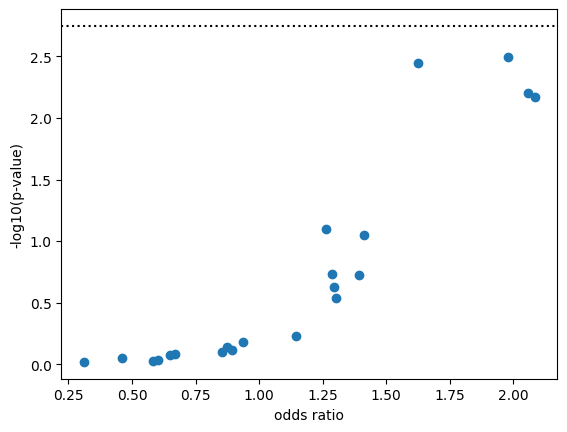

In [54]:
t=enr_tbl
plt.scatter(x=enr_tbl.odds_ratio,y=-np.log10(enr_tbl.p_intersect))
plt.xlabel('odds ratio')
plt.ylabel('-log10(p-value)')
plt.axhline(-np.log10(0.05/len(par)),color='black',ls=':',label='bonferroni')

texts = []
for i in t.index:
    if (t.p_intersect[i]<(0.05/len(enr_tbl))):
        texts.append(plt.annotate(t.trait[i], (t.odds_ratio[i], -np.log10(t.p_intersect[i]))))

# Adjust text to avoid overlap
adjust_text(texts, only_move={'points': 'y', 'texts': 'y'}, 
            arrowprops=dict(arrowstyle="->", color='black', lw=0.5))


plt.show()

enrichments look very odd... not sure why